## Data Analysis with NYC airbnb data 

This project will analyze and provide insights on the demographic characteristic of the NYC hosts. We will also touch base on pricing prediction model to provide a pricing guideline for future airbnb host

The data used in this project is NYC Airbnb Open Data: 
https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data 

In [385]:
# importing library 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import seaborn as sns
import tensorflow as tf
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

### 1. Preprocessing and Data Exploration

In [386]:
# Loading data into notebook and convert to appropriate data types
try:
    nyc_img = Image.open('New_York_city_.png')
except IOError:
    pass
types = {'id':'int64', 'name':'str', 'neighbourhood_group':'object', 
         'room_type':'category', 'price': 'float'}
airbnb = pd.read_csv('AB_NYC_2019.csv', sep = ',', dtype = types)
airbnb['last_review'] = pd.to_datetime(airbnb['last_review'])
print(airbnb.shape)
print(airbnb.dtypes)

(48895, 16)
id                                         int64
name                                      object
host_id                                    int64
host_name                                 object
neighbourhood_group                       object
neighbourhood                             object
latitude                                 float64
longitude                                float64
room_type                               category
price                                    float64
minimum_nights                             int64
number_of_reviews                          int64
last_review                       datetime64[ns]
reviews_per_month                        float64
calculated_host_listings_count             int64
availability_365                           int64
dtype: object


In [387]:
# take a brief look at the data 
airbnb.head(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149.0,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225.0,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150.0,3,0,NaT,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89.0,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80.0,10,9,2018-11-19,0.10,1,0


In [388]:
# remove duplicated values if there i any
airbnb.duplicated().sum()
airbnb.drop_duplicates(inplace = True)

In [389]:
# Summary statisics for feature column
print(airbnb['room_type'].unique())
print(airbnb['neighbourhood_group'].unique())
print(airbnb[['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month']].describe().T)

[Private room, Entire home/apt, Shared room]
Categories (3, object): [Private room, Entire home/apt, Shared room]
['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']
                     count        mean         std   min    25%     50%  \
price              48895.0  152.720687  240.154170  0.00  69.00  106.00   
minimum_nights     48895.0    7.029962   20.510550  1.00   1.00    3.00   
number_of_reviews  48895.0   23.274466   44.550582  0.00   1.00    5.00   
reviews_per_month  38843.0    1.373221    1.680442  0.01   0.19    0.72   

                      75%      max  
price              175.00  10000.0  
minimum_nights       5.00   1250.0  
number_of_reviews   24.00    629.0  
reviews_per_month    2.02     58.5  


In [390]:
airbnb.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

We won't treat the missing values in columns 'host_name' and 'name' since it is not relevant to our data analysis. 'host_id' and 'id' can be used instead of 'host_name' and 'name' (Note: we can drop these 2 columns if wanted but I will keep it here for reference). 10052 missing values in 'last_review' and 'reviews_per_month' means that for that specific host, there are no available reviews. We will just change the null value in the 'reviews_per_month' into zeros ( note: fill in the null values with average do not make sense in this case)

In [391]:
airbnb.fillna({'reviews_per_month': 0}, inplace = True)
# check if the change is applied
airbnb['reviews_per_month'].isnull().sum()

0

Let dwell into it a little bit more. First, we will see who has the most listings and which area has the most listings

In [488]:
most_host = airbnb['host_id'].value_counts().nlargest(5)
print(most_host)
# validate with 'calculated_host_listings_count' column
airbnb['calculated_host_listings_count'].max()

219517861    327
107434423    232
30283594     121
137358866    103
12243051      96
Name: host_id, dtype: int64


327

In [489]:
most_host = np.array(most_host)
count = []
for count in most_host:
    print(airbnb['neighbourhood_group'].loc[airbnb['calculated_host_listings_count'] == count].unique())
    print(airbnb[['neighbourhood_group', 'room_type']].loc[airbnb['calculated_host_listings_count'] == count].describe())

#print(airbnb['neighbourhood_group'].loc[airbnb['calculated_host_listings_count'] == 232].unique())
#print(airbnb[['neighbourhood_group', 'room_type']].loc[airbnb['calculated_host_listings_count'] == 232].describe())
#print(airbnb['neighbourhood_group'].loc[airbnb['calculated_host_listings_count'] == 121].unique())
#print(airbnb[['neighbourhood_group', 'room_type']].loc[airbnb['calculated_host_listings_count'] == 121].describe())
#print(airbnb['neighbourhood_group'].loc[airbnb['calculated_host_listings_count'] == 103].unique())
#print(airbnb[['neighbourhood_group', 'room_type']].loc[airbnb['calculated_host_listings_count'] == 103].describe())
#print(airbnb['neighbourhood_group'].loc[airbnb['calculated_host_listings_count'] == 96].unique())
#print(airbnb[['neighbourhood_group', 'room_type']].loc[airbnb['calculated_host_listings_count'] == 96].describe())

['Manhattan']
       neighbourhood_group        room_type
count                  327              327
unique                   1                2
top              Manhattan  Entire home/apt
freq                   327              319
['Manhattan' 'Brooklyn']
       neighbourhood_group        room_type
count                  232              232
unique                   2                1
top              Manhattan  Entire home/apt
freq                   230              232
['Manhattan']
       neighbourhood_group        room_type
count                  121              121
unique                   1                1
top              Manhattan  Entire home/apt
freq                   121              121
['Manhattan' 'Queens' 'Brooklyn']
       neighbourhood_group     room_type
count                  103           103
unique                   3             2
top                 Queens  Private room
freq                    79           101
['Manhattan']
       neighbourhood_group        

We can see that hosting homes are dominantly in the Manhattan areas for the host in top 6 numbers of listings. The room types are mostly entire home/apt. Lets take a look at the overall number of listings in these neighborhood groups

Text(0.5, 1.0, 'Number of listings in neighborhood groups ')

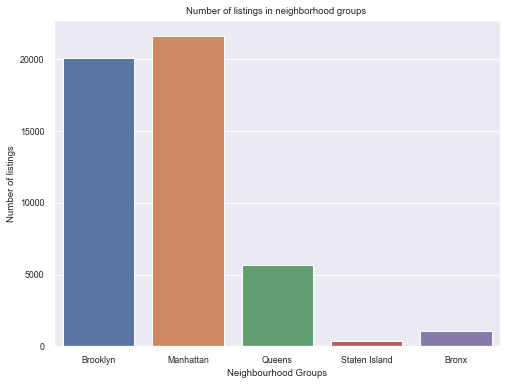

In [394]:
plt.figure(figsize = (8,6))
sns.countplot(x = 'neighbourhood_group',  data = airbnb)
plt.xlabel('Neighbourhood Groups')
plt.ylabel('Number of listings')
plt.title('Number of listings in neighborhood groups ')

Manhattan and Brooklyn seems to be the two dominant areas for hosting. What about the pricing in each borough?  

Text(0.5, 1.0, 'Price Distribution within each borough')

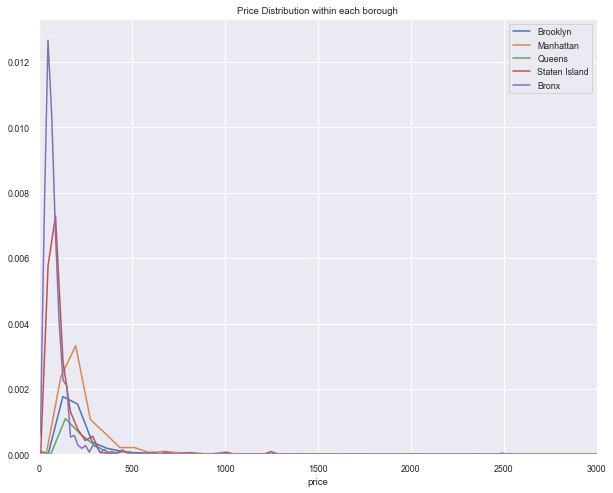

In [395]:
plt.figure(figsize = (10,8))
names = []
for names in airbnb['neighbourhood_group'].unique():
        sns.distplot(airbnb[airbnb['neighbourhood_group'] == names].price
                 ,hist = False, label = names) 
plt.xlim(0,3000)
plt.title('Price Distribution within each borough')

(0, 1000)

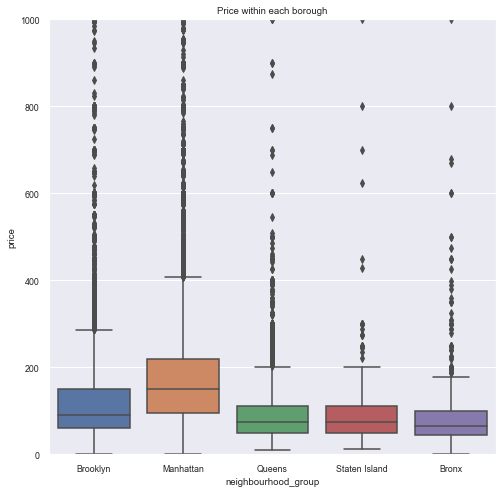

In [396]:
plt.figure(figsize  = (8,8))
sns.boxplot(x = 'neighbourhood_group', y = 'price', data = airbnb)
plt.title('Price within each borough')
plt.ylim(0,1000)

Averagely, Manhattan and Brooklyn has the most expensive accomodation

Text(0.5, 1.0, 'Share of Room Types within Neighbourhood Groups ')

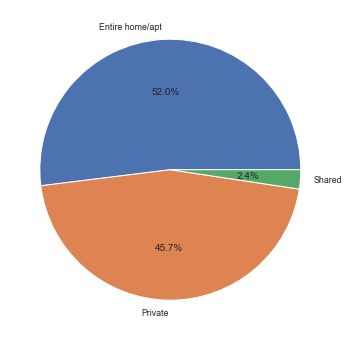

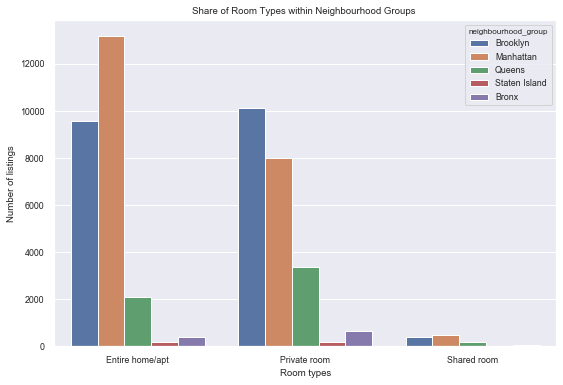

In [423]:
plt.figure(figsize = (6,6))
plt.pie(airbnb['room_type'].value_counts(), 
        labels = ['Entire home/apt', 'Private', 'Shared'], autopct='%1.1f%%', data = airbnb)

plt.figure(figsize = (9,6))
sns.countplot(x = 'room_type', hue = 'neighbourhood_group', data = airbnb)
plt.xlabel('Room types')
plt.ylabel('Number of listings')
plt.title('Share of Room Types within Neighbourhood Groups ')

We can see that most of listings are in entire home/apt and private room types. Next, lets look into the map and analyze the distribution of availability of room. 

,count,mean,std,min,25%,50%,75%,max
neighbourhood_group,,,,,,,,
Bronx,1091.0,87.496792,106.709349,0.0,45.0,65.0,99.0,2500.0
Brooklyn,20104.0,124.383207,186.873538,0.0,60.0,90.0,150.0,10000.0
Manhattan,21661.0,196.875814,291.383183,0.0,95.0,150.0,220.0,10000.0
Queens,5666.0,99.517649,167.102155,10.0,50.0,75.0,110.0,10000.0
Staten Island,373.0,114.812332,277.620403,13.0,50.0,75.0,110.0,5000.0


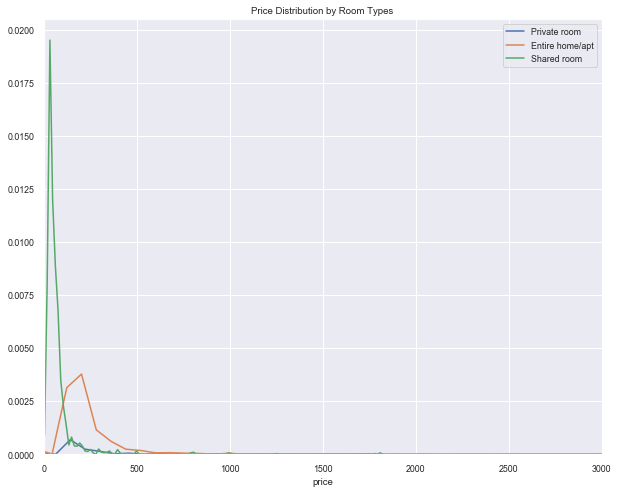

In [398]:

plt.figure(figsize = (10,8))
names = []
for names in airbnb['room_type'].unique():
        sns.distplot(airbnb[airbnb['room_type'] == names].price
                 ,hist = False, label = names) 
plt.xlim(0,3000)
plt.title('Price Distribution by Room Types')

airbnb.groupby('neighbourhood_group')['price'].describe()


Clearly, shared room's cost is the cheapest and entire room/apt is generally the most costly when we look at the distribution plot above. Lets see how price is related to those 

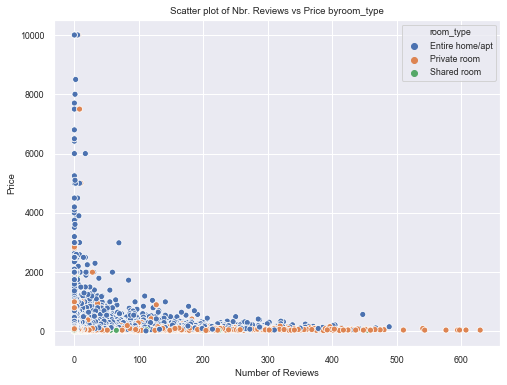

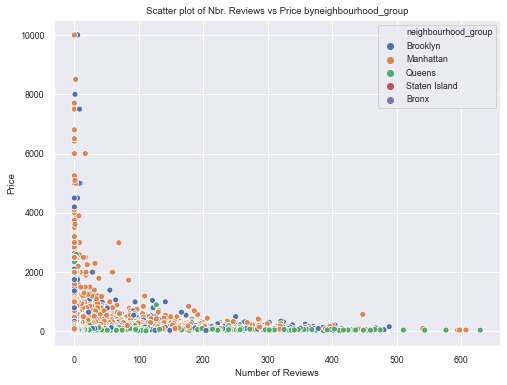

In [441]:
hueopt = ['room_type', 'neighbourhood_group']
segment = []
for segment in hueopt: 
    plt.figure(figsize=(8,6))
    sns.scatterplot(airbnb['number_of_reviews'], airbnb['price'], hue = airbnb[segment])
    plt.xlabel('Number of Reviews')
    plt.ylabel('Price')
    plt.title('Scatter plot of Nbr. Reviews vs Price by' + str(segment))

Most of reviews are from host with relatively low price , approximately less than $1000. Highest numbers of reviews come from private room followed by entire home/apt. There do not seem to be any relationship between the  
Now, we will look into the correlation matrix 

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
id,1,0.59,-0.0031,0.091,0.011,-0.013,-0.32,0.18,0.13,0.085
host_id,0.59,1,0.02,0.13,0.015,-0.017,-0.14,0.21,0.15,0.2
latitude,-0.0031,0.02,1,0.085,0.034,0.025,-0.015,-0.019,0.02,-0.011
longitude,0.091,0.13,0.085,1,-0.15,-0.063,0.059,0.14,-0.11,0.083
price,0.011,0.015,0.034,-0.15,1,0.043,-0.048,-0.051,0.057,0.082
minimum_nights,-0.013,-0.017,0.025,-0.063,0.043,1,-0.08,-0.12,0.13,0.14
number_of_reviews,-0.32,-0.14,-0.015,0.059,-0.048,-0.08,1,0.59,-0.072,0.17
reviews_per_month,0.18,0.21,-0.019,0.14,-0.051,-0.12,0.59,1,-0.047,0.16
calculated_host_listings_count,0.13,0.15,0.02,-0.11,0.057,0.13,-0.072,-0.047,1,0.23
availability_365,0.085,0.2,-0.011,0.083,0.082,0.14,0.17,0.16,0.23,1


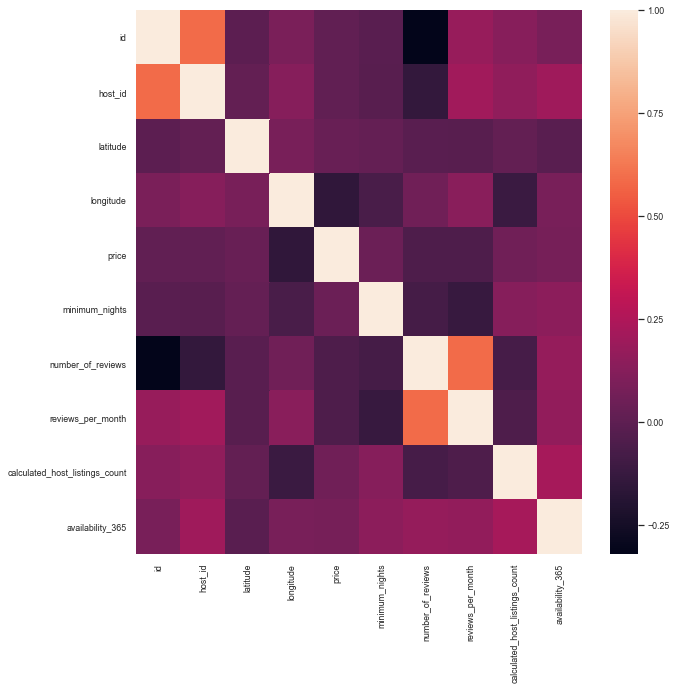

In [421]:
f = plt.figure(figsize = (10,10))
sns.heatmap(airbnb.corr())

airbnb.corr().style.background_gradient().set_precision(2)

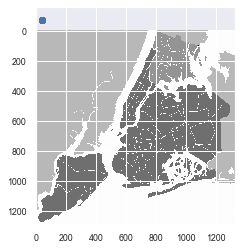

In [490]:
plt.imshow(nyc_img)
sns.scatterplot(airbnb['latitude'], airbnb['longitude'])

In [491]:
?sns.scatterplot

## 2.  Price Prediction